# Experiment 20: Length-Controlled Padding

**Question**: Is the priming failure on long NQ docs a **length effect** or a **dataset effect**?

MS MARCO and NQ differ in many ways (passage style, question type, answer format). Exp 18 showed
priming works on short MS MARCO (d=+0.30) and short NQ (d=+0.33) but fails on long NQ (medium/long/very_long all negative).
Exp 18 also ruled out the distance hypothesis (periodic beacons didn't help).

**Design**: Take MS MARCO samples where priming works, artificially pad them with unrelated MS MARCO
passages to reach target token lengths, and test whether the benefit disappears as length increases.
This isolates the length variable while keeping domain/style constant.

| Target Length | What it tests |
|---|---|
| original (~80-130 tok) | Baseline where priming works (d≈+0.30) |
| 256 | Still short |
| 512 | Medium (~NQ medium bin) |
| 1024 | Long (~NQ long bin) |
| 2048 | Very long (~NQ very_long bin) |

2 conditions (bare, single_prefix) × 5 lengths = 10 scores per sample.

In [1]:
# Cell 1: Setup & Imports
import os
os.umask(0o000)  # File permission safety (two-user environment)

import json
import time
import numpy as np
import torch
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lib.config import ExperimentConfig
from lib.kv_cache import (
    extract_and_truncate_cache_with_bos,
    correct_rope_positions_with_bos,
    score_answer_with_cache,
    deepcopy_cache,
)
from lib.analysis import cohens_d
from lib.surrogate import STATIC_SURROGATE_QUERIES

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Paths
RESULTS_DIR = Path('results/exp20')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Model
MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.2'
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=bnb_config, device_map='auto'
)
config = ExperimentConfig(device='cuda')

print(f'Model loaded: {MODEL_NAME}')
print(f'Device: {config.device}')
print(f'Results dir: {RESULTS_DIR}')

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded: mistralai/Mistral-7B-Instruct-v0.2
Device: cuda
Results dir: results/exp20


In [2]:
# Cell 2: Configuration

N_SAMPLES = 300
TARGET_LENGTHS = [None, 256, 512, 1024, 2048]  # None = original length
CHECKPOINT_EVERY = 25

# Prefix text (static_factual — best performer, same as Exp 07/17/18)
BEACON_TEXT = STATIC_SURROGATE_QUERIES['static_factual']['query']

# Templates (matched to Exp 07/17/18)
QUERY_TEMPLATE = '\nQuery: {query}\nAnswer:'
ANSWER_TEMPLATE = ' {answer}'

# Paths
CHECKPOINT_PATH = RESULTS_DIR / 'checkpoint.json'
RESULTS_PATH = RESULTS_DIR / 'results.json'

print(f'N_SAMPLES: {N_SAMPLES}')
print(f'TARGET_LENGTHS: {TARGET_LENGTHS}')
print(f'Prefix text: "{BEACON_TEXT}"')
print(f'Checkpoint every: {CHECKPOINT_EVERY} samples')

N_SAMPLES: 300
TARGET_LENGTHS: [None, 256, 512, 1024, 2048]
Prefix text: "What are the key facts I need to know?"
Checkpoint every: 25 samples


In [3]:
# Cell 3: Build Padding Pool

from lib.data import load_ms_marco, load_evaluation_samples

# Load MS MARCO
msmarco_dataset = load_ms_marco(config)
all_samples = load_evaluation_samples(msmarco_dataset, config, require_answer=True)

# First 300 = evaluation set (same as Exp 17/18)
eval_samples = all_samples[:N_SAMPLES]
print(f'Evaluation samples: {len(eval_samples)}')

# Build padding pool from ALL passages in the raw dataset (not just selected ones).
# We need ~614K tokens but load_evaluation_samples only yields ~2500 samples (~275K tokens).
# The raw dataset has ~10K rows × ~10 passages each = plenty of text.
eval_passages = set(s['passage'] for s in eval_samples)
padding_passages = []

for item in msmarco_dataset:
    passages = item.get('passages', {})
    passage_texts = passages.get('passage_text', [])
    for p in passage_texts:
        if p not in eval_passages:
            padding_passages.append(p)

print(f'Padding pool passages: {len(padding_passages):,}')

# Concatenate and pre-tokenize
padding_text = ' '.join(padding_passages)
print(f'Padding text length: {len(padding_text):,} characters')

padding_ids = tokenizer.encode(padding_text, add_special_tokens=False)
print(f'Padding pool tokens: {len(padding_ids):,}')

# Verify pool is large enough (need at most 2048 * 300 = 614,400)
max_needed = 2048 * N_SAMPLES
print(f'Max tokens needed: {max_needed:,}')
assert len(padding_ids) > max_needed, (
    f'Padding pool too small: {len(padding_ids):,} < {max_needed:,}. '
    f'Need more padding samples.'
)
print(f'Pool is {len(padding_ids) / max_needed:.1f}x the max needed. OK.')

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading microsoft/ms_marco dataset...


Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 2500 samples
Evaluation samples: 300


Padding pool passages: 82,054
Padding text length: 34,634,454 characters


Padding pool tokens: 8,757,884
Max tokens needed: 614,400
Pool is 14.3x the max needed. OK.


In [4]:
# Cell 4: Explain Experimental Conditions
print('=' * 70)
print('EXPERIMENTAL CONDITIONS EXPLAINED')
print('=' * 70)

# Concrete example with a real eval sample
ex = eval_samples[0]
ex_ids = tokenizer.encode(ex['passage'], add_special_tokens=False)
prefix_ids = tokenizer.encode(BEACON_TEXT + '\n', add_special_tokens=False)

print(f'\nExample passage: {len(ex_ids)} tokens')
print(f'  "{ex["passage"][:80]}..."')
print(f'Prefix: {len(prefix_ids)} tokens ("{BEACON_TEXT}")')
print()

print('### At each target length, we score two conditions: ###')
print()
print('  bare:          [BOS] + [doc_ids] -> forward -> score')
print('  single_prefix: [BOS] + [prefix_ids] + [doc_ids] -> forward -> truncate -> RoPE correct -> score')
print()
print('Both use IDENTICAL doc_ids at each length. Only the prefix differs.')
print()

n_ex = len(ex_ids)
n_pfx = len(prefix_ids)
print(f'--- Target: original ({n_ex} tokens) ---')
print(f'  bare:          [BOS][doc({n_ex})] = {1 + n_ex} tokens total')
print(f'  single_prefix: [BOS][prefix({n_pfx})][doc({n_ex})] -> truncate -> [BOS][doc_primed({n_ex})]')
print(f'  This is the baseline where priming works (d~+0.30).')
print()

for tl in [256, 512, 2048]:
    pad_needed = max(0, tl - n_ex)
    actual_len = max(tl, n_ex)
    print(f'--- Target: {tl} tokens ---')
    if pad_needed > 0:
        print(f'  doc_ids = original({n_ex}) + padding({pad_needed}) = {actual_len} tokens')
        print(f'  Padding: unrelated MS MARCO passages appended at token level')
    else:
        print(f'  doc_ids = original({n_ex}) (already >= {tl}, no padding needed)')
    print(f'  bare:          [BOS][doc({actual_len})] = {1 + actual_len} tokens total')
    print(f'  single_prefix: [BOS][prefix({n_pfx})][doc({actual_len})] -> truncate -> [BOS][doc_primed({actual_len})]')
    print(f'  Answer span stays at the BEGINNING -- only total cache size changes.')
    print()

EXPERIMENTAL CONDITIONS EXPLAINED

Example passage: 122 tokens
  "Usually planted in the early fall, cool-season grass seeds prefer daytime temper..."
Prefix: 11 tokens ("What are the key facts I need to know?")

### At each target length, we score two conditions: ###

  bare:          [BOS] + [doc_ids] -> forward -> score
  single_prefix: [BOS] + [prefix_ids] + [doc_ids] -> forward -> truncate -> RoPE correct -> score

Both use IDENTICAL doc_ids at each length. Only the prefix differs.

--- Target: original (122 tokens) ---
  bare:          [BOS][doc(122)] = 123 tokens total
  single_prefix: [BOS][prefix(11)][doc(122)] -> truncate -> [BOS][doc_primed(122)]
  This is the baseline where priming works (d~+0.30).

--- Target: 256 tokens ---
  doc_ids = original(122) + padding(134) = 256 tokens
  Padding: unrelated MS MARCO passages appended at token level
  bare:          [BOS][doc(256)] = 257 tokens total
  single_prefix: [BOS][prefix(11)][doc(256)] -> truncate -> [BOS][doc_primed(256)]


In [5]:
# Cell 5: Helper Function

def score_at_length(passage_ids, padding_ids_pool, target_len,
                    beacon_text, model, tokenizer, config,
                    query_prompt, answer_text):
    """Score bare and single_prefix for a passage padded to target_len tokens.

    If target_len is None, use original passage length.
    If passage is already >= target_len, use original (no padding needed).

    Returns: {'bare': nll, 'single_prefix': nll, 'actual_len': int}
    """
    doc_ids = list(passage_ids)  # copy

    # Pad if needed
    if target_len is not None and len(doc_ids) < target_len:
        pad_needed = target_len - len(doc_ids)
        # Random start offset into padding pool for diversity
        max_start = len(padding_ids_pool) - pad_needed
        start = np.random.randint(0, max_start)
        doc_ids.extend(padding_ids_pool[start:start + pad_needed])

    actual_len = len(doc_ids)
    bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else 1
    bos_tensor = torch.tensor([[bos_id]], device=config.device)
    doc_tensor = torch.tensor([doc_ids], device=config.device)

    results = {'actual_len': actual_len}

    # --- bare ---
    bare_input = torch.cat([bos_tensor, doc_tensor], dim=1)
    with torch.no_grad():
        out = model(
            input_ids=bare_input,
            attention_mask=torch.ones_like(bare_input),
            use_cache=True, return_dict=True,
        )
    results['bare'] = score_answer_with_cache(
        deepcopy_cache(out.past_key_values), bare_input.shape[1],
        query_prompt, answer_text, model, tokenizer, config,
    )
    del out

    # --- single_prefix ---
    prefix_text = beacon_text + '\n'
    prefix_ids = tokenizer.encode(prefix_text, add_special_tokens=False)
    prefix_tensor = torch.tensor([prefix_ids], device=config.device)
    full_input = torch.cat([bos_tensor, prefix_tensor, doc_tensor], dim=1)
    prefix_token_len = 1 + len(prefix_ids)  # BOS + prefix

    with torch.no_grad():
        out = model(
            input_ids=full_input,
            attention_mask=torch.ones_like(full_input),
            use_cache=True, return_dict=True,
        )
    truncated = extract_and_truncate_cache_with_bos(out.past_key_values, actual_len)
    surrogate_offset = prefix_token_len - 1
    correct_rope_positions_with_bos(truncated, surrogate_offset, model)
    keep_len = 1 + actual_len
    results['single_prefix'] = score_answer_with_cache(
        deepcopy_cache(truncated), keep_len,
        query_prompt, answer_text, model, tokenizer, config,
    )
    del out, truncated

    torch.cuda.empty_cache()
    return results


print('Helper function defined.')

Helper function defined.


In [6]:
# Cell 6: Evaluation Loop

all_results = []
start_idx = 0

# Resume from checkpoint if available
if CHECKPOINT_PATH.exists():
    with open(CHECKPOINT_PATH, 'r') as f:
        ckpt = json.load(f)
    ckpt_queries = ckpt.get('sample_queries', [])
    current_queries = [s['query'] for s in eval_samples]
    if ckpt_queries == current_queries:
        all_results = ckpt['results']
        start_idx = len(all_results)
        print(f'Resuming from checkpoint: {start_idx}/{N_SAMPLES}')
    else:
        print('Checkpoint sample mismatch. Starting fresh.')

for idx in tqdm(range(start_idx, N_SAMPLES), initial=start_idx, total=N_SAMPLES,
                desc='Eval'):
    sample = eval_samples[idx]
    query_prompt = QUERY_TEMPLATE.format(query=sample['query'])
    answer_text = ANSWER_TEMPLATE.format(answer=sample['answer'])

    # Tokenize passage once
    passage_ids = tokenizer.encode(sample['passage'], add_special_tokens=False)

    sample_result = {
        'idx': idx,
        'word_count': len(sample['passage'].split()),
        'original_token_len': len(passage_ids),
    }

    for tl in TARGET_LENGTHS:
        length_key = 'original' if tl is None else str(tl)
        scores = score_at_length(
            passage_ids, padding_ids, tl,
            BEACON_TEXT, model, tokenizer, config,
            query_prompt, answer_text,
        )
        sample_result[f'bare_{length_key}'] = scores['bare']
        sample_result[f'prefix_{length_key}'] = scores['single_prefix']
        sample_result[f'actual_len_{length_key}'] = scores['actual_len']

    all_results.append(sample_result)

    # Checkpoint
    if (idx + 1) % CHECKPOINT_EVERY == 0 or idx == N_SAMPLES - 1:
        ckpt_data = {
            'results': all_results,
            'sample_queries': [s['query'] for s in eval_samples],
            'completed': len(all_results),
            'total': N_SAMPLES,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        }
        with open(CHECKPOINT_PATH, 'w') as f:
            json.dump(ckpt_data, f)

print(f'Evaluation complete: {len(all_results)} samples')

Eval:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluation complete: 300 samples


In [7]:
# Cell 7: Analysis

length_keys = ['original', '256', '512', '1024', '2048']

print('=' * 70)
print('LENGTH-CONTROLLED PADDING ANALYSIS')
print('=' * 70)
print()
print(f'{"Length":<12} {"Mean Bare":>10} {"Mean Prefix":>12} {"Mean Δ":>10} {"d":>8} {"Win%":>7} {"p":>12} {"sig":>5}')
print('-' * 80)

analysis = {}

for lk in length_keys:
    bare_arr = np.array([r[f'bare_{lk}'] for r in all_results])
    prefix_arr = np.array([r[f'prefix_{lk}'] for r in all_results])
    actual_lens = np.array([r[f'actual_len_{lk}'] for r in all_results])

    # Filter invalid
    valid = np.isfinite(bare_arr) & np.isfinite(prefix_arr) & (bare_arr != 0) & (prefix_arr != 0)
    bare = bare_arr[valid]
    prefix = prefix_arr[valid]
    lens = actual_lens[valid]
    n_valid = int(np.sum(valid))

    delta = bare - prefix  # positive = prefix helps
    d = cohens_d(delta)
    win = np.mean(delta > 0) * 100
    t_stat, p_val = stats.ttest_1samp(delta, 0)
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'

    label = lk if lk == 'original' else f'{lk} tok'
    print(f'{label:<12} {np.mean(bare):>10.4f} {np.mean(prefix):>12.4f} {np.mean(delta):>+10.4f} {d:>+8.3f} {win:>6.1f}% {p_val:>12.2e} {sig:>5}')

    analysis[lk] = {
        'n_valid': n_valid,
        'mean_bare': float(np.mean(bare)),
        'mean_prefix': float(np.mean(prefix)),
        'mean_delta': float(np.mean(delta)),
        'cohens_d': float(d),
        'win_pct': float(win),
        't_stat': float(t_stat),
        'p_value': float(p_val),
        'mean_actual_len': float(np.mean(lens)),
    }

print()
print('Prediction: d should decay from ~+0.30 at original to ~0 or negative at 2048.')

LENGTH-CONTROLLED PADDING ANALYSIS

Length        Mean Bare  Mean Prefix     Mean Δ        d    Win%            p   sig
--------------------------------------------------------------------------------
original         1.0975       1.0254    +0.0721   +0.303   66.5%     7.71e-07   ***
256 tok          1.0218       0.9959    +0.0259   +0.114   64.7%     5.88e-02    ns
512 tok          0.9550       0.9485    +0.0065   +0.034   58.3%     5.70e-01    ns
1024 tok         0.9075       0.9156    -0.0081   -0.043   55.0%     4.72e-01    ns
2048 tok         0.8890       0.8909    -0.0019   -0.014   57.6%     8.13e-01    ns

Prediction: d should decay from ~+0.30 at original to ~0 or negative at 2048.


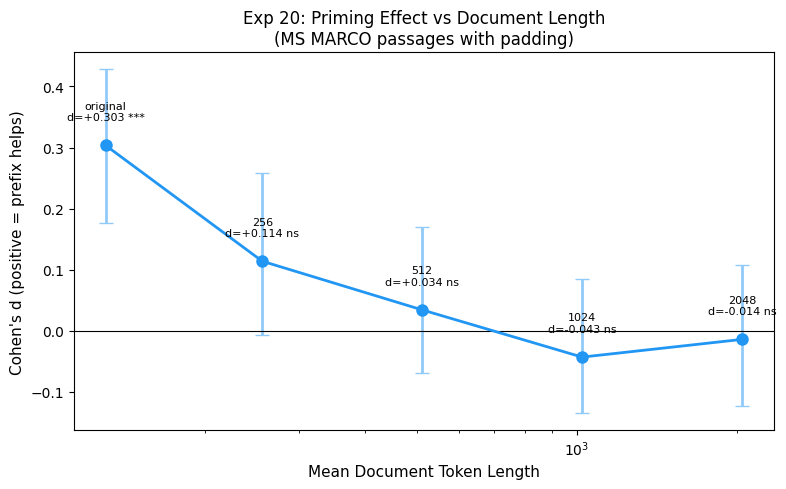

Saved: results/exp20/figures/d_vs_length.png


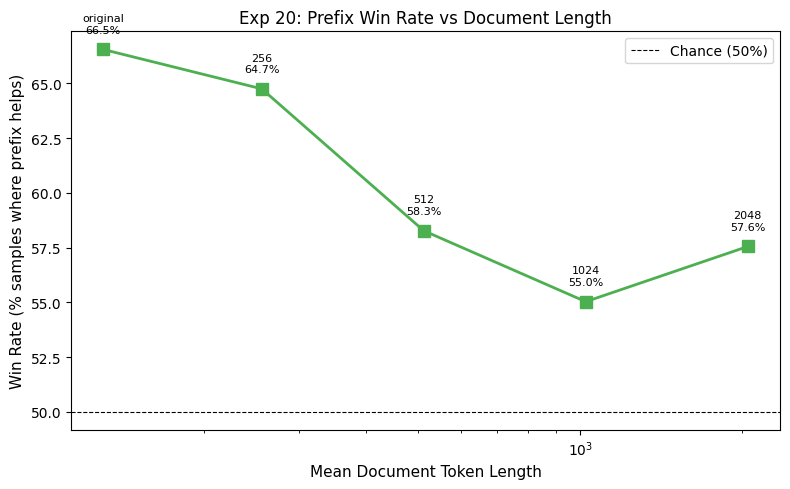

Saved: results/exp20/figures/winrate_vs_length.png


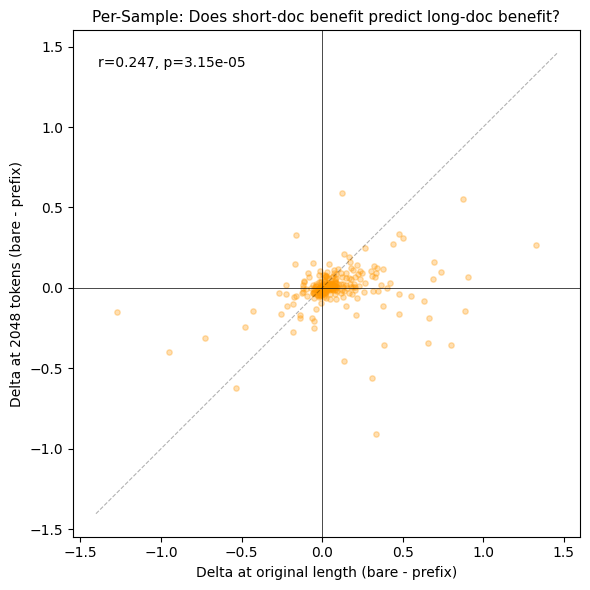

Saved: results/exp20/figures/delta_scatter.png

EXPERIMENT 20 SUMMARY

Question: Is priming failure on long docs a LENGTH effect or DATASET effect?

  original     d=+0.303  win=67%  p=7.71e-07  ***  → HELPS
  256 tok      d=+0.114  win=65%  p=5.88e-02  ns  → NEUTRAL
  512 tok      d=+0.034  win=58%  p=5.70e-01  ns  → NEUTRAL
  1024 tok     d=-0.043  win=55%  p=4.72e-01  ns  → NEUTRAL
  2048 tok     d=-0.014  win=58%  p=8.13e-01  ns  → NEUTRAL

CONCLUSION: LENGTH is likely the primary factor. Priming benefit decays
with document length even within MS MARCO, not just across datasets.

All results saved to results/exp20/


In [8]:
# Cell 8: Figures & Summary

length_keys = ['original', '256', '512', '1024', '2048']

# Compute arrays for plotting
ds_plot = []
wins_plot = []
x_lengths = []
ci_lo = []
ci_hi = []

# Also collect per-sample deltas for scatter
deltas_by_length = {}

for lk in length_keys:
    bare_arr = np.array([r[f'bare_{lk}'] for r in all_results])
    prefix_arr = np.array([r[f'prefix_{lk}'] for r in all_results])
    valid = np.isfinite(bare_arr) & np.isfinite(prefix_arr) & (bare_arr != 0) & (prefix_arr != 0)
    bare = bare_arr[valid]
    prefix = prefix_arr[valid]
    delta = bare - prefix

    d = cohens_d(delta)
    win = np.mean(delta > 0) * 100

    # Bootstrap 95% CI for Cohen's d
    np.random.seed(SEED)
    boot_ds = []
    for _ in range(2000):
        idx_boot = np.random.randint(0, len(delta), size=len(delta))
        boot_ds.append(cohens_d(delta[idx_boot]))
    boot_ds = np.array(boot_ds)
    ci_lo.append(np.percentile(boot_ds, 2.5))
    ci_hi.append(np.percentile(boot_ds, 97.5))

    ds_plot.append(d)
    wins_plot.append(win)
    actual_lens = np.array([r[f'actual_len_{lk}'] for r in all_results])[valid]
    x_lengths.append(np.mean(actual_lens))
    deltas_by_length[lk] = delta

ds_plot = np.array(ds_plot)
wins_plot = np.array(wins_plot)
x_lengths = np.array(x_lengths)
ci_lo = np.array(ci_lo)
ci_hi = np.array(ci_hi)

# --- Figure 1: Cohen's d vs Target Length ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x_lengths, ds_plot,
            yerr=[ds_plot - ci_lo, ci_hi - ds_plot],
            marker='o', markersize=8, linewidth=2, capsize=5,
            color='#2196F3', ecolor='#90CAF9')

# Annotate significance
for i, lk in enumerate(length_keys):
    p = analysis[lk]['p_value']
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    label = lk if lk == 'original' else f'{lk}'
    ax.annotate(f'{label}\nd={ds_plot[i]:+.3f} {sig}',
                (x_lengths[i], ds_plot[i]),
                textcoords='offset points', xytext=(0, 18),
                ha='center', fontsize=8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xscale('log')
ax.set_xlabel('Mean Document Token Length', fontsize=11)
ax.set_ylabel("Cohen's d (positive = prefix helps)", fontsize=11)
ax.set_title('Exp 20: Priming Effect vs Document Length\n(MS MARCO passages with padding)', fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'd_vs_length.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "d_vs_length.png"}')

# --- Figure 2: Win Rate vs Length ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_lengths, wins_plot, marker='s', markersize=8, linewidth=2, color='#4CAF50')
ax.axhline(y=50, color='black', linestyle='--', linewidth=0.8, label='Chance (50%)')
for i, lk in enumerate(length_keys):
    label = lk if lk == 'original' else f'{lk}'
    ax.annotate(f'{label}\n{wins_plot[i]:.1f}%',
                (x_lengths[i], wins_plot[i]),
                textcoords='offset points', xytext=(0, 12),
                ha='center', fontsize=8)
ax.set_xscale('log')
ax.set_xlabel('Mean Document Token Length', fontsize=11)
ax.set_ylabel('Win Rate (% samples where prefix helps)', fontsize=11)
ax.set_title('Exp 20: Prefix Win Rate vs Document Length', fontsize=12)
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'winrate_vs_length.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "winrate_vs_length.png"}')

# --- Figure 3: Per-sample scatter (delta at 2048 vs delta at original) ---
fig, ax = plt.subplots(figsize=(6, 6))
d_orig = deltas_by_length['original']
d_2048 = deltas_by_length['2048']
# Align lengths (both should be same if all valid, but intersect to be safe)
n_scatter = min(len(d_orig), len(d_2048))
ax.scatter(d_orig[:n_scatter], d_2048[:n_scatter], alpha=0.3, s=15, color='#FF9800')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
# Diagonal
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=0.8)
ax.set_xlabel('Delta at original length (bare - prefix)', fontsize=10)
ax.set_ylabel('Delta at 2048 tokens (bare - prefix)', fontsize=10)
ax.set_title('Per-Sample: Does short-doc benefit predict long-doc benefit?', fontsize=11)
from scipy.stats import pearsonr
r, p = pearsonr(d_orig[:n_scatter], d_2048[:n_scatter])
ax.annotate(f'r={r:.3f}, p={p:.2e}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=10, va='top')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'delta_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "delta_scatter.png"}')

# --- Summary ---
print()
print('=' * 70)
print('EXPERIMENT 20 SUMMARY')
print('=' * 70)
print()
print('Question: Is priming failure on long docs a LENGTH effect or DATASET effect?')
print()
for lk in length_keys:
    a = analysis[lk]
    label = lk if lk == 'original' else f'{lk} tok'
    sig = '***' if a['p_value'] < 0.001 else '**' if a['p_value'] < 0.01 else '*' if a['p_value'] < 0.05 else 'ns'
    verdict = 'HELPS' if a['cohens_d'] > 0 and a['p_value'] < 0.05 else 'HURTS' if a['cohens_d'] < 0 and a['p_value'] < 0.05 else 'NEUTRAL'
    print(f'  {label:<12} d={a["cohens_d"]:+.3f}  win={a["win_pct"]:.0f}%  p={a["p_value"]:.2e}  {sig}  → {verdict}')

print()
if analysis['original']['cohens_d'] > 0.1 and analysis['2048']['cohens_d'] < 0.05:
    print('CONCLUSION: LENGTH is likely the primary factor. Priming benefit decays')
    print('with document length even within MS MARCO, not just across datasets.')
elif analysis['2048']['cohens_d'] > 0.1:
    print('CONCLUSION: DATASET is likely the primary factor. Priming benefit persists')
    print('even at NQ-like lengths when the content is MS MARCO-style.')
else:
    print('CONCLUSION: Mixed signal. See detailed numbers above.')

# Save analysis
final = {
    'experiment': 'exp20_length_controlled_padding',
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    'config': {
        'model_name': MODEL_NAME, 'seed': SEED, 'n_eval': N_SAMPLES,
        'dataset': 'MS MARCO v1.1', 'prefix_text': BEACON_TEXT,
        'target_lengths': [str(tl) if tl else 'original' for tl in TARGET_LENGTHS],
    },
    'analysis': analysis,
    'per_sample_results': all_results,
}
with open(RESULTS_PATH, 'w') as f:
    json.dump(final, f, indent=2)
print(f'\nAll results saved to {RESULTS_DIR}/')